<font size=10> **Introduction** </font>

The primary function of this notebook was to:

-  Clean/preprocess raw data scraped from AllTrails (see scrape_data for details of how the data was scraped)
-  Train a collaborative filtering recommendation system
-  Train a hybrid collaborative filtering and content-based recommendation system. 
-  Tune hyperparameters of the models in order to maximize performance.

The python module LightFM was utilized to build the recommendation system models. 

<font size=10> **Import Libraries** </font><

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import coo_matrix
from scipy import sparse
import collections
from lightfm import LightFM
from lightfm import data
from lightfm import cross_validation
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score
from lightfm.evaluation import precision_at_k
from numpy import dot
from numpy.linalg import norm

%matplotlib inline
sns.set()

/Users/stefanheinze/anaconda3/envs/insight/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


<font size=10> **Import hike data** </font>

Here we import the raw data scraped from the AllTrails website.

In [3]:
hike_data = pd.read_pickle('../data/all_hike_data')
hike_data.head(1)

,hike_name,hike_difficulty,hike_distance,hike_elevation,hike_type,hike_tags,hike_description,user_names,user_hrefs,user_texts,user_ratings,user_dates
0,Taft Point and The Fissures - California\n |...,EASY,2.3 miles,374 feet,Out & Back,"[kid friendly, birding, hiking, horseback ridi...",Taft Point and The Fissures is a 2.3 mile mode...,"[Soua Lee, Jeff Allen, Nicole Edmonds, Marie K...","[/members/soua-lee-3, /members/jeff-allen-41, ...",[Incredible hike! I would do this again althou...,"[5, 4, 5, 4, 1, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, ...","[2018-11-13 00:00:00, 2018-11-05 00:00:00, 201..."


In [5]:
print('The shape of the hike_data dataframe is {} (hikes) by {} (features).'.format(hike_data.shape[0], hike_data.shape[1]))

The shape of the hike_data dataframe is 5367 (hikes) by 12 (features).


<font size=6> **Data Wrangling** </u></font>

In this section, we convert the raw data into a form that will be useful for our eventual hybrid collaborative filtering and content-based recommendation system. This includes:
-  (1) Removing unwanted text from the hike names.
-  (2) Building the interactions matrix from the user reviews.

 <font size=6> 1. Correct hike names </font>

The hike_name column in the hike_data dataframe contains the text "California | AllTrails" appended to the end of the name, as well as some newline characters. We should remove these for clarity.

In [8]:
def correct_hike_names(df):
    '''Removes "California | AllTrails" text from hike names, as well as new line characters.
    
    Returns: Nothing. Replaces the hike_name column with a new column where the strings are fixed.'''
    
    df['hike_name'] = df['hike_name'].str.replace('\n', '').str.replace('- California \| AllTrails', '').str.strip()

In [9]:
correct_hike_names(hike_data)

Let's print the first five hikes and make sure that the "California | AllTrails" text and newline characters are removed. 

In [7]:
hike_data.loc[:5, 'hike_name']

0               Taft Point and The Fissures
1    Aliso Creek and Wood Canyon Loop Trail
2                Upper Natural Bridge Trail
3                        Lake Miramar Trail
4                    McGinty Mountain Trail
5                   San Antonio Falls Trail
Name: hike_name, dtype: object

All looks good, so let's move on.

<font size=6> 2. Filter data and build interaction matrix </font>

In [10]:
def gen_collabfilt_matrix(df):
    '''Generates an interaction matrix for collaborative filtering from the raw AllTrails dataframe (df). 
    Note that each interaction will be a rating from 1-5.
    
    Returns: Interaction matrix as pandas DataFrame.'''
    
    # Initialize dictionary where each key will be the name of a hike and the associated value will itself be a dictionary 
    # where each key is a user that rated the hike and each value is the associated rating.
    hike_user_rating_dict = {} 
    
    # Grab relevant information from each hike, construct the {user_name: user_rating} dictionary, and add it to hike_user_rating_dict.
    for hike_index in range(df.shape[0]):
        hike_name = df.loc[hike_index, 'hike_name'] 
        user_names = df.loc[hike_index, 'user_names'] # This is a list
        user_ratings = df.loc[hike_index, 'user_ratings'] # This is a list
        
        # Construct {user_name: user_rating} dictionary by looping through user_names and user_ratings.
        user_rating_dict = {} 
        for user_index in range(len(user_names)): 
            user_rating_dict[user_names[user_index]] = user_ratings[user_index] 
        
        # Add user_rating_dict to hike_user_rating_dict
        hike_user_rating_dict[hike_name] = user_rating_dict
    
    return pd.DataFrame(hike_user_rating_dict, dtype='int')

Now we can generate the interaction matrix using gen_collabfilt_matrix.

In [11]:
hike_user_rating_matrix = gen_collabfilt_matrix(hike_data)

The current interaction matrix has ratings from 1-5, but we would like to convert this to 1 or 0 (interacted with the hike or did not interact with the hike, respectively. We need to create a function to binarize the 1-5 scale to 1 or 0.

In [12]:
def convert_to_binary(df, cutoff):
    '''Threshold an interaction matrix such that if a rating is below a certain value, the value is changed to 0;
    otherwise the value is changed to 1. A "1" indicates that there is a positive interaction between the user-item pair and
    a "0" indicates there is no interaction between the user-item pair.
    
    Returns: Thresholded interaction matrix as pandas DataFrame.'''
    
    df = df.fillna(0)
    df[df < cutoff] = 0
    df[df > cutoff] = 1
    
    return df

Now we can binarize the interaction matrix uxing convert_to_binary. We'll use a cutoff of 2.5, meaning that a rating of 3 or above will be considered as a positive interaction for the interaction matrix.

In [13]:
df = convert_to_binary(hike_user_rating_matrix, 2.5)

Now that we have a binarized interaction matrix, we are going to filter out some of our data. For instance, it would not be great to include hikes that have no ratings or users that have only rated a single hike. In order to see what effect this filtering process has on the data, let's construct a function that returns some basic stats about the filtered dataframe.

In [16]:
def get_basic_stats(df):
    '''Prints the number of hikes, number of unique users, number of ratings, and sparsity (percentage of entries that are 1) 
    of the interaction matrix. Assumes that the matrix has already been binarized (only contains 1s and 0s).'''

    num_users = df.shape[0]
    num_hikes = df.shape[1]
    num_ratings = df.values.sum()
    sparsity = num_ratings / (num_hikes * num_users) * 100

    print('Number of hikes: ' + str(num_hikes))
    print('Number of users: ' + str(num_users))
    print('Number of ratings: {:.0f}'.format(num_ratings))
    print('Sparsity = {:4.2f}%'.format(sparsity))

What are the stats for the interaction matrix before filtering?

In [15]:
get_basic_stats(df)

Number of hikes: 5295
Number of users: 104434
Number of ratings: 217146
Sparsity = 0.04%


Let's start by filtering any user that has less than 5 reviews.

In [96]:
df = df[df.apply(np.sum, axis=1) > 4.5]

In [97]:
get_basic_stats(df)

Number of hikes: 5295
Number of users: 8630
Number of ratings: 77481
Sparsity = 0.17%


Filtering any user with less than 5 reviews removed ~96,000 users (92% of users) and 140,000+ reviews (64% of reviews).
Now let's filter any hike that has no ratings.

In [98]:
df = df.loc[:, (df != 0).any(axis=0)]

In [130]:
get_basic_stats(df)

Number of hikes: 4615
Number of users: 8630
Number of ratings: 77481
Sparsity = 0.19%


Approximately 700 hikes had no reviews.

Let's save the column names and filtered interaction matrix for future use.

In [131]:
pd.Series(df.columns).to_pickle('column_names_190129')
df.to_pickle('hike_data_filtered_190129')

<font size=10> **Build Collaborative Filtering Model** </font> 

In this section, we utilize the interaction matrix built in the previous section in order to build a purely collaborative filtering based recommendation system.

<font size=6> 1. Build model </font>

In [692]:
def lightfm_implicit_matrix(df):
    '''Utilizes the interaction matrix (df) from the previous section to create Dataset and Interactions LightFM objects, 
    which are needed to train a recommendation system model.
    
    Returns: (Dataset, Interactions) tuple, the latter as a sparse matrix (CSR)'''
    
    dataset = data.Dataset()
    dataset.fit((user for user in df.index),
                (item for item in df.columns)) # Creates mappings for users and items within LightFM
    num_users, num_items = dataset.interactions_shape() 
    interaction_list = list(df[df > 0].stack().index) # Get user-item pairs for positive interactions
    interactions, weights = dataset.build_interactions((x[0], x[1]) for x in interaction_list) # Build Interactions object within LightFM
    
    return dataset, interactions

def lightfm_train(train, num_components, num_epochs):
    '''Train a LightFM collaborative filtering model from a training set.
    
    Returns: LightFM recommendation system model.'''
    
    # Set parameters for model
    NUM_THREADS = 1
    NUM_COMPONENTS = num_components
    NUM_EPOCHS = num_epochs
    ITEM_ALPHA = 1e-6 # Recommended by LightFM

    # Let's fit a WARP model: these generally have the best performance.
    model = LightFM(loss='warp',
                    item_alpha=ITEM_ALPHA,
                    no_components=NUM_COMPONENTS)

    # Fit model
    model = model.fit(train, epochs=NUM_EPOCHS, num_threads=NUM_THREADS)
    
    return model

Load in the saved interaction matrix

In [693]:
interaction_matrix = pd.read_pickle('../data/less_filtered/hike_data_filtered_190129')

Let's train a LightFM collaborative fitlering model

In [694]:
dataset, interactions = lightfm_implicit_matrix(interaction_matrix)
train, test = cross_validation.random_train_test_split(interactions, test_percentage=0.2, random_state=np.random.RandomState(seed=1)) # Create train/test set
model = lightfm_train(train, 30, 30)

Now that we have a model, let's compute and print the AUC score on the training set.

In [159]:
train_auc = auc_score(model=model, test_interactions=train, num_threads=1).mean()
print('Collaborative filtering train AUC: %s' % train_auc)

Collaborative filtering train AUC: 0.99702007


Let's compute and print the AUC score on the test set. Note that we pass in the train_interactions to exclude them from the predictions. This is to simulate a recommender system where we do not re-recommend things the user has already interacted with in the training set.

In [160]:
test_auc = auc_score(model=model, test_interactions=test, train_interactions=train, num_threads=1).mean()
print('Collaborative filtering test AUC: %s' % test_auc)

Collaborative filtering test AUC: 0.9138105


The AUC suggests that the model is performing well. Another metric that is commonly utilized to validate recommendation systems is precision-at-k, which calculates, on average across all users, the fraction of recommended items that the users have positive interactions with. Note that this excludes items that have been used in the training set.

In [104]:
for k in range(1,11):
    precision = precision_at_k(model, test_interactions=test, train_interactions=train, k=k).mean()
    print('Precision at k = {} is {:.3f}'.format(k, precision))

Precision at k = 1 is 0.074
Precision at k = 2 is 0.067
Precision at k = 3 is 0.061
Precision at k = 4 is 0.056
Precision at k = 5 is 0.052
Precision at k = 6 is 0.049
Precision at k = 7 is 0.047
Precision at k = 8 is 0.044
Precision at k = 9 is 0.043
Precision at k = 10 is 0.041


The precision-at-k drops monotonically with increasing k, as should be expected. Let's compare the precision-at-5 against two baselines, one where the most popular hikes are predicted and one where hikes are randomly recommended.

To compute the baseline precision-at-5 where the most popular hikes are recommended we need to know:

-  The number of positive interactions for the 5 most popular hikes. (1)
-  The number of users in the interaction matrix. (2)   

The baseline value will be (1) / ((2) * 5). The 5 in this equations exists since 5 hikes are being recommended to each user.

In [697]:
interaction_matrix.apply(np.sum).sort_values(ascending=False)[:5].sum() / (df.shape[0]*5)

0.04757821552723059

To compute the baseline where hikes are randomly recommended we need to know:

-  The total number of positive interactions in the interactions matrix (1)
-  The total number of possible user-item pairs (2)

The value (1) / (2) gives the fraction of positive interactions (e.g. 1s) in the interactions matrix (also called the sparsity). This value times 5 should be the expected value for randomly recommending 5 hikes to the users.

In [698]:
interaction_matrix.apply(np.sum).sum() / (interaction_matrix.shape[0] * interaction_matrix.shape[1]) * 5

0.0019454170427682415

Based on the precision-at-5, our model performs comparably to recommending the most popular hikes to each user and much better than recommending random hikes to each user. 

<font size=6> 2. Tune hyperparameters </font>

In this section we quickly tune the hyperparameters of our model. We optimize the following hyperparameters:
-  number of components
-  number of epochs
-  learning rate

We start by tuning the number of components and number of epochs.

In [187]:
# The following code fits a LightFM collaborative filtering model for various combinations of number of components and number of epochs.
# The precision-at-5 is calculated for each model and the results are stored in a nested list. The first level will contain 5 lists, 
# one for each unique value of number of components. The second level contains 5 lists, one for each unique value of number of epochs. 
# These lists have form [num_epochs, precision-at-5]

# First level of list
components_k_vs_epochs = []

for num_components in [10, 30, 50, 75, 100]: 
    print('Starting components = {}'.format(num_components)) # For monitoring status
    
    # Second level of list
    k_vs_epochs = [] 
    for num_epochs in np.arange(0, 55, 5):
        # Fit model
        dataset, interactions = lightfm_implicit_matrix(interaction_matrix)
        train, test = cross_validation.random_train_test_split(interactions, test_percentage=0.2, random_state=np.random.RandomState(seed=1))
        model = lightfm_train(train, num_components=num_components, num_epochs=num_epochs)
        
        # Calculate precision-at-5
        precision = precision_at_k(model, test_interactions=test, train_interactions=train, k=5).mean()
        
        # Add results to first level of list
        k_vs_epochs.append([num_epochs, precision])
        
    print('Finished components = {}'.format(num_components)) # For monitoring status
    components_k_vs_epochs.append(k_vs_epochs)

Starting components = 10
Finished components = 10
Starting components = 30
Finished components = 30
Starting components = 50
Finished components = 50
Starting components = 75
Finished components = 75
Starting components = 100
Finished components = 100


Great, it worked! Let's visualize our results on a lineplot.

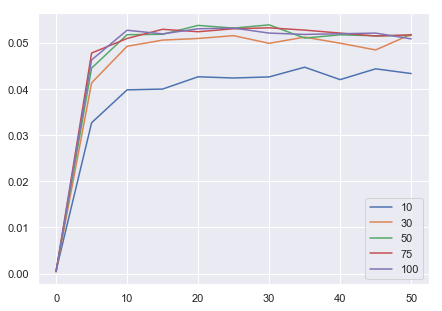

In [188]:
plt.figure(figsize=(7,5))
num_components = [10, 30, 50, 75, 100]
for index in range(len(components_k_vs_epochs)):
    plt.plot([ item[0] for item in components_k_vs_epochs[index]], [ item[1] for item in components_k_vs_epochs[index] ], 
             label=num_components[index])
plt.legend()

It looks like 30 components are enough, since adding more components doesn't change the precision-at-5. Furthermore only 10 training epochs are required, since the plots flattern out after 10 training epochs.

Now we do the same exercise for the learning rate instead of the number of components.

In [185]:
# The following code fits a LightFM collaborative filtering model for various combinations of learning rate and number of epochs.
# The precision-at-5 is calculated for each model and the results are stored in a nested list. The first level will contain 5 lists, 
# one for each unique value of learning rate. The second level contains 5 lists, one for each unique value of number of epochs. 
# These lists have form [num_epochs, precision-at-5]

# First level of list
learningrate_k_vs_epochs = []

for learning_rate in [1e-4, 1e-3, 1e-2, 1e-1, 1]:
    print('Starting learning rate = {}'.format(learning_rate)) # For monitoring purposes
    
    # Second level of list
    k_vs_epochs = []
    for num_epochs in [5, 10, 15, 20]:
        
        # Fit model
        dataset, interactions = lightfm_implicit_matrix(interaction_matrix)
        train, test = cross_validation.random_train_test_split(interactions, test_percentage=0.2, random_state=np.random.RandomState(seed=1))
        model = lightfm_train(train, num_components=30, num_epochs=num_epochs)
        
        # Calculate precision-at-5
        precision = precision_at_k(model, test_interactions=test, train_interactions=train, k=5).mean()
        
        # Add results to first level of list
        k_vs_epochs.append([num_epochs, precision])
        
    print('Finished learning rate = {}'.format(learning_rate))
    learningrate_k_vs_epochs.append(k_vs_epochs)    

Starting learning rate = 0.0001
Finished learning rate = 0.0001
Starting learning rate = 0.001
Finished learning rate = 0.001
Starting learning rate = 0.01
Finished learning rate = 0.01
Starting learning rate = 0.1
Finished learning rate = 0.1
Starting learning rate = 1
Finished learning rate = 1


Great! That worked. Let's visualize our results on a lineplot.

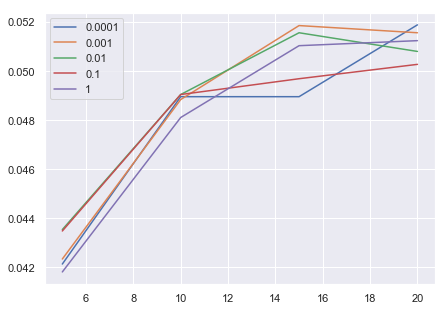

In [186]:
plt.figure(figsize=(7,5))
learning_rate = [1e-4, 1e-3, 1e-2, 1e-1, 1]
for index in range(len(learningrate_k_vs_epochs)):
    plt.plot([ item[0] for item in learningrate_k_vs_epochs[index]], [ item[1] for item in learningrate_k_vs_epochs[index] ], 
             label=learning_rate[index])
plt.legend()

It doesn't look like the learning rate substantially influences the precision-at-5. Also, the plot shows that we should use at least 15 epochs.

<font size=6> 3. Analyze diversity of recommendations </font>

In this section, we analyze the "diversity of recommendations" for our collaborative filtering model. The "diversity of recommendations"  is the number of unique hikes recommended to all users when k hikes are recommended to each user.

Let's start by loading in the data.

In [258]:
interaction_matrix = pd.read_pickle('../data/less_filtered/hike_data_filtered_190129')
top_hikes = interaction_matrix.apply(np.sum).sort_values(ascending=False)[:10]

We'll need the LightFM mapping for users and items. This will allow us to know the hike names that are being recommended

In [233]:
item_map = dataset.mapping()[2] 

Now we define a function that will convert the index of a LightFM item (hike) to the actual hike name.

In [ ]:
def find_item(lfm_map, lfm_index):
    '''Converts the LightFM index of an item (hike) to the actual hike name.
    
    Returns: name of hike associated with LightFM item index.'''
    
    return [ key for key in lfm_map.keys() if lfm_map[key] == lfm_index ][0]

In [259]:
# Create a list of all unique hikes recommended to 100 users when 10 hikes are recommended to those 100 users. 

hike_names = []
for index in range(100): 
    predictions = model.predict(index, np.arange(interactions._shape[1])) # Predict ranking of each hike for a user
    sorted_by_index = (-1*predictions).argsort() # Sort descending

    # For top 10 hikes of each user, convert LightFM hike index to hike name
    for pred_num in range(10):
        hike_name = find_item(item_map, sorted_by_index[pred_num])
        hike_names.append(hike_name)

In [265]:
num_hikes_recommended = len(collections.Counter(hike_names).most_common())
print('Number of hikes recommended is: {}.\nNumber of hikes expected if only using top 10 hikes is: 10'.format(num_hikes_recommended))

Number of hikes recommended is: 408.
Number of hikes expected if only using top 10 hikes is: 10


One of the nice things about the collaborative filtering recommendation system is that a much larger set of hikes are recommended to the user base, presumably as a result of each users' preferences.

<font size=10> Incorporate item features </font>

<font size=6> 1. Get unique hike tags </font>

In [136]:
hike_data.shape

(5367, 12)

In [111]:
tag_count = dict(collections.Counter(hike_data['hike_tags'].sum()))

In [112]:
sorted_by_count = sorted(tag_count.items(), key=lambda x: x[1], reverse=True)

In [113]:
sorted_by_count[:5]

[('hiking', 4982),
 ('views', 4612),
 ('walking', 4027),
 ('nature trips', 3919),
 ('birding', 3362)]

In [114]:
delete_list = ['blowdown','bridge out', 'closed', 'muddy', 'no dogs', 'no shade', 'off road driving', 'off trail',
               'paddle sports', 'paved', 'private property', 'rails trails', 'surfing', 'washed out', 'city walk',
              'cross country skiing', 'hiking', 'partially paved', 'road biking', 'skiing', 'nature trips', 'snowshoeing',
              'dogs on leash']

In [115]:
final_tags = list(tag_count.keys())
for item in delete_list:
    final_tags.remove(item)
final_tags[:5]
# ADD dog friendly and dog on leash together

['kid friendly', 'birding', 'horseback riding', 'trail running', 'walking']

<font size=6> 2. Get hike features and build feature matrix </font>

In [116]:
unique_difficulties = hike_data['hike_difficulty'].unique() # unique hike difficulties
unique_types = hike_data['hike_type'].unique() # unique hike_types
unique_tags = set(hike_data['hike_tags'].sum())

In [117]:
hike_feature_df = hike_data.copy()
hike_feature_df['hike_distance'] = hike_feature_df['hike_distance'].str.extract('(\d+.\d)'); # extract distance
hike_feature_df['hike_elevation'] = hike_feature_df['hike_elevation'].str.replace(',', '').str.extract('(\d+)')

In [118]:
def get_hike_features(df, index):

    hike_features_dict = {}
    easy = 0
    moderate = 0
    hard = 0
    out_and_back = 0
    loop = 0
    point_to_point = 0

    if df.iloc[index]['hike_difficulty'] == 'EASY':
        easy = 1
    elif df.iloc[index]['hike_difficulty'] == 'MODERATE':
        moderate = 1
    else:
        hard = 1

    if df.iloc[index]['hike_type'] == 'Out & Back':
        out_and_back = 1
    elif df.iloc[index]['hike_type'] == 'Loop':
        loop = 1
    else:
        point_to_point = 1
        
    tag_dict = {}
    for feature in final_tags:
        if feature in hike_data.iloc[index]['hike_tags']:
            tag_dict[feature] = 1
        else:
            tag_dict[feature] = 0
    if 'dogs on leash' in hike_data.iloc[index]['hike_tags']:
        tag_dict['dog friendly'] = 1
        
    hike_distance = df.iloc[index]['hike_distance']
    hike_elevation = df.iloc[index]['hike_elevation']
        
    hike_features_dict['difficulty_easy'] = easy
    hike_features_dict['difficulty_moderate'] = moderate
    hike_features_dict['difficulty_hard'] = hard
    hike_features_dict['out_and_back'] = out_and_back
    hike_features_dict['loop'] = loop
    hike_features_dict['point_to_point'] = point_to_point
    hike_features_dict['hike_distance'] = float(hike_distance)
    hike_features_dict['hike_elevation'] = float(hike_elevation)
    for item in tag_dict.items(): # add tags in dict
        hike_features_dict[item[0]] = item[1]
    
    return hike_features_dict

In [119]:
hikes_features = {}
for index in hike_feature_df.index:
    hike_features_dict = get_hike_features(hike_feature_df, index)
    hikes_features[hike_feature_df.iloc[index]['hike_name']] = hike_features_dict

In [121]:
hikes_features_df = pd.DataFrame(hikes_features).T
hikes_features_df.head(5)

,backpacking,beach,birding,bugs,camping,cave,difficulty_easy,difficulty_hard,difficulty_moderate,dog friendly,...,scramble,snow,stroller friendly,trail running,views,walking,waterfall,wheelchair friendly,wild flowers,wildlife
Taft Point and The Fissures,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
Aliso Creek and Wood Canyon Loop Trail,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
Upper Natural Bridge Trail,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
Lake Miramar Trail,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
McGinty Mountain Trail,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0


In [122]:
logmean_hike_distance = np.mean(np.log(hikes_features_df['hike_distance'])) # log distance
logstd_hike_distance = np.std(np.log(hikes_features_df['hike_distance'])) # log distance
logmean_hike_elevation = np.mean(np.log(hikes_features_df['hike_elevation'][hikes_features_df['hike_elevation'] != 0]))
logstd_hike_elevation = np.std(np.log(hikes_features_df['hike_elevation'][hikes_features_df['hike_elevation'] != 0]))

In [123]:
def classify_distance(row):
    if np.log(row) < logmean_hike_distance-logstd_hike_distance:
        return "Short"
    elif np.log(row) < logmean_hike_distance+logstd_hike_distance and np.log(row) > logmean_hike_distance-logstd_hike_distance:
        return "Medium"
    else:
        return "Long"

In [124]:
def classify_elevation(row):
    if np.log(row) < logmean_hike_elevation-logstd_hike_elevation:
        return "Easy"
    elif np.log(row) < logmean_hike_elevation+logstd_hike_elevation and np.log(row) > logmean_hike_elevation-logstd_hike_elevation:
        return "Medium"
    else:
        return "Hard"

In [125]:
categorized_distances = hikes_features_df['hike_distance'].apply(classify_distance)
categorized_elevations = hikes_features_df['hike_elevation'].apply(classify_elevation)

In [126]:
hikes_features_df['hike_elevation'] = categorized_elevations
hikes_features_df['hike_distance'] = categorized_distances

In [127]:
for index in hikes_features_df.index:
    if hikes_features_df.loc[index, 'hike_distance'] == 'Short':
        hikes_features_df.loc[index, 'distance_short'] = 1
    elif hikes_features_df.loc[index, 'hike_distance'] == 'Medium':
        hikes_features_df.loc[index, 'distance_medium'] = 1
    else:
        hikes_features_df.loc[index, 'distance_long'] = 1
        
    if hikes_features_df.loc[index, 'hike_elevation'] == 'Easy':
        hikes_features_df.loc[index, 'elevation_easy'] = 1
    elif hikes_features_df.loc[index, 'hike_elevation'] == 'Medium':
        hikes_features_df.loc[index, 'elevation_medium'] = 1
    else:
        hikes_features_df.loc[index, 'elevation_hard'] = 1

    
hikes_features_df.drop(labels='hike_distance', axis=1, inplace=True)
hikes_features_df.drop(labels='hike_elevation', axis=1, inplace=True)
hikes_features_df.fillna(0, inplace=True);

In [128]:
hikes_features_df.head()

,backpacking,beach,birding,bugs,camping,cave,difficulty_easy,difficulty_hard,difficulty_moderate,dog friendly,...,waterfall,wheelchair friendly,wild flowers,wildlife,distance_medium,elevation_medium,elevation_easy,distance_short,distance_long,elevation_hard
Taft Point and The Fissures,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
Aliso Creek and Wood Canyon Loop Trail,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
Upper Natural Bridge Trail,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
Lake Miramar Trail,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
McGinty Mountain Trail,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [141]:
df = pd.read_pickle('../data/less_filtered/hike_data_filtered_190129')
print(df.shape)
df.head(1)

(8630, 4615)


,Taft Point and The Fissures,Aliso Creek and Wood Canyon Loop Trail,Upper Natural Bridge Trail,Lake Miramar Trail,McGinty Mountain Trail,San Antonio Falls Trail,The Slot,Panoramic Hill - Chaparral Peak - Strawberry Canyon Loop,Lafayette Reservoir Nature Area Rim Trail,Cleo's Bath Trail via Pinecrest Lake Loop,...,Rae Lakes Trail,Congress Trail,Strawberry Canyon Fire Trail,Annie's Canyon via North Rios Trail,Lake Margaret Trail,Deep Creek Hot Springs Trail,Cougar Crest Trail,Abalone Cove Trail,"Torrey Pines - Red Butte, Yucca Point, and Razor Point",Soberanes Canyon Trail
B B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [142]:
hikes_features_df = hikes_features_df.loc[df.columns] # limit df to those hikes in interaction matrix

In [143]:
hikes_features_df = hikes_features_df[~hikes_features_df.index.duplicated(keep='last')]

In [144]:
hikes_features_df.shape

(4615, 42)

In [146]:
hikes_features_df.to_pickle('hike_features_190129b')

<font size=10> Hybrid Recommendation with item features </font>

<font size=6> 1. Build model </font>

In [267]:
hikes_features_df = pd.read_pickle('../data/less_filtered/hike_features_190129b')
df = pd.read_pickle('../data/less_filtered/hike_data_filtered_190129')

In [268]:
item_features = hikes_features_df.columns
hike_features_dict = {row: column.dropna().to_dict() for row, column in hikes_features_df.T[hikes_features_df.T != 0].T.iterrows()}

In [277]:
def lightfm_implicit_matrix(df, hikes_features_df): #df should be pandas interaction matrix
    dataset = data.Dataset() # Instantiate class
    dataset.fit(users=(user for user in df.index),
                items=(item for item in df.columns),
                item_features=(feature for feature in hikes_features_df.columns)) # Create users and items from df
    num_users, num_items = dataset.interactions_shape() # Get shape
    interaction_list = list(df[df > 0].stack().index) # Get interaction pairs
    interactions, weights = dataset.build_interactions((x[0], x[1]) for x in interaction_list) # Build interactions
    hike_features_dict = {row: column.dropna().to_dict() for row, column in hikes_features_df.T[hikes_features_df.T != 0].T.iterrows()}
    feature_matrix = dataset.build_item_features([ (key, value) for key,value in hike_features_dict.items() ]) # Build item_features matrix
    
    return dataset, interactions, feature_matrix

def lightfm_train(train, item_features, num_components=30, num_epochs=10, learning_rate=0.05):
    num_threads = 1
    item_alpha = 1e-6
    learning_rate = learning_rate

    # Let's fit a WARP model: these generally have the best performance.
    model = LightFM(loss='warp',
                    learning_rate = learning_rate,
                    item_alpha=item_alpha,
                    no_components=num_components)

    model = model.fit(interactions=train, item_features=item_features, epochs=num_epochs, num_threads=num_threads)
    
    return model

def find_item(lfm_map, lfm_index):
    return [ key for key in lfm_map.keys() if lfm_map[key] == lfm_index ][0]

def return_top_10_new_user(interactions, model, item_map, item_features=None):
    predictions = model.predict(interactions._shape[0]-1, np.arange(interactions._shape[1]), item_features=item_features)
    sorted_by_index = (-1*predictions).argsort()
    names = []
    
    for pred_num in range(10):
        name = find_item(item_map, sorted_by_index[pred_num])
        print('Prediction {} is {}.'.format(pred_num+1, name))
        names.append(name)
        
    return names

In [194]:
dataset, interactions, feature_matrix = lightfm_implicit_matrix(df, hikes_features_df)
train, test = cross_validation.random_train_test_split(interactions, test_percentage=0.2, random_state=np.random.RandomState(seed=1))
model = lightfm_train(train, feature_matrix, 30, 30)

In [195]:
# Compute and print the AUC score
train_auc = auc_score(model=model, test_interactions=train, item_features=feature_matrix, num_threads=30).mean()
print('Collaborative filtering train AUC: %s' % train_auc)

Collaborative filtering train AUC: 0.93562055


In [196]:
# We pass in the train interactions to exclude them from predictions.
# This is to simulate a recommender system where we do not
# re-recommend things the user has already interacted with in the train
# set.
test_auc = auc_score(model=model, test_interactions=test, train_interactions=train, item_features=feature_matrix, num_threads=30).mean()
print('Collaborative filtering test AUC: %s' % test_auc)

Collaborative filtering test AUC: 0.8341182


In [154]:
for k in range(1,11):
    precision = precision_at_k(model, test_interactions=test, train_interactions=train, item_features=feature_matrix, k=k).mean()
    print('Precision at k = {} is {:.2f}'.format(k, precision))

Precision at k = 1 is 0.03
Precision at k = 2 is 0.03
Precision at k = 3 is 0.03
Precision at k = 4 is 0.02
Precision at k = 5 is 0.02
Precision at k = 6 is 0.02
Precision at k = 7 is 0.02
Precision at k = 8 is 0.02
Precision at k = 9 is 0.02
Precision at k = 10 is 0.02


<font size=6> 2. Tune hyperparameters </font>

In [197]:
grid_search = {}
count = 0
for learning_rate in [1e-4, 1e-2, 1]:
    for num_epochs in [20, 40]:
        for num_components in [20, 40]:
            dataset, interactions, feature_matrix = lightfm_implicit_matrix(df, hikes_features_df)
            train, test = cross_validation.random_train_test_split(interactions, test_percentage=0.2, random_state=np.random.RandomState(seed=1))
            model = lightfm_train(train, item_features=feature_matrix, num_components=num_components, num_epochs=num_epochs, learning_rate=learning_rate)
            test_auc = auc_score(model, test, train_interactions=train, item_features=feature_matrix, num_threads=1).mean()
            precision = precision_at_k(model, test, train_interactions=train, item_features=feature_matrix, k=5).mean()
            grid_search[count] = {'lr': learning_rate, 'ne': num_epochs, 'nc': num_components, 'auc': test_auc, 'precision': precision}
            count += 1

In [198]:
sorted(grid_search.items(), key=lambda x: x[1]['precision'], reverse=True)[:5]

[(10,
  {'lr': 1, 'ne': 40, 'nc': 20, 'auc': 0.86745214, 'precision': 0.026680306}),
 (8, {'lr': 1, 'ne': 20, 'nc': 20, 'auc': 0.858922, 'precision': 0.025160726}),
 (11,
  {'lr': 1, 'ne': 40, 'nc': 40, 'auc': 0.852623, 'precision': 0.024284044}),
 (9,
  {'lr': 1, 'ne': 20, 'nc': 40, 'auc': 0.84576905, 'precision': 0.020777322}),
 (7,
  {'lr': 0.01,
   'ne': 40,
   'nc': 40,
   'auc': 0.7665115,
   'precision': 0.009380478})]

In [200]:
grid_search2 = {}
count = 0
for learning_rate in [1, 10, 50]:
    for num_epochs in [40, 80]:
        for num_components in [10, 20]:
            dataset, interactions, feature_matrix = lightfm_implicit_matrix(df, hikes_features_df)
            train, test = cross_validation.random_train_test_split(interactions, test_percentage=0.2, random_state=np.random.RandomState(seed=1))
            model = lightfm_train(train, item_features=feature_matrix, num_components=num_components, num_epochs=num_epochs, learning_rate=learning_rate)
            test_auc = auc_score(model, test, train_interactions=train, item_features=feature_matrix, num_threads=1).mean()
            precision = precision_at_k(model, test, train_interactions=train, item_features=feature_matrix, k=5).mean()
            grid_search2[count] = {'lr': learning_rate, 'ne': num_epochs, 'nc': num_components, 'auc': test_auc, 'precision': precision}
            count += 1

In [210]:
sorted(grid_search2.items(), key=lambda x: x[1]['precision'], reverse=True)[:5]

[(2,
  {'lr': 1, 'ne': 80, 'nc': 10, 'auc': 0.8935133, 'precision': 0.034307424}),
 (0,
  {'lr': 1, 'ne': 40, 'nc': 10, 'auc': 0.8870859, 'precision': 0.031706605}),
 (3,
  {'lr': 1, 'ne': 80, 'nc': 20, 'auc': 0.87305367, 'precision': 0.029924022}),
 (1,
  {'lr': 1, 'ne': 40, 'nc': 20, 'auc': 0.86913747, 'precision': 0.027352424}),
 (11,
  {'lr': 50, 'ne': 80, 'nc': 20, 'auc': 0.5004089, 'precision': 0.0005844535})]

In [218]:
k_vs_epochs = []
for num_epochs in [5, 10, 50, 100, 200, 500, 1000, 2000]:
    dataset, interactions, feature_matrix = lightfm_implicit_matrix(df, hikes_features_df)
    train, test = cross_validation.random_train_test_split(interactions, test_percentage=0.2, random_state=np.random.RandomState(seed=1))
    model = lightfm_train(train, item_features=feature_matrix, num_components=10, num_epochs=num_epochs, learning_rate=1)
    test_auc = auc_score(model, test, train_interactions=train, item_features=feature_matrix, num_threads=1).mean()
    precision = precision_at_k(model, test, train_interactions=train, item_features=feature_matrix, k=5).mean()
    k_vs_epochs.append([num_epochs, precision])

Text(0.5, 1.0, '"Learning curve" for Hybrid Recommendation on test set')

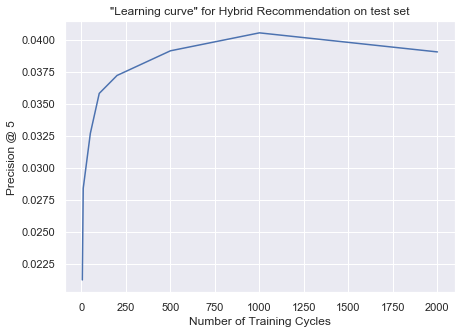

In [222]:
plt.figure(figsize=(7,5))
num_epochs = [5, 10, 50, 100, 200]
plt.plot([ item[0] for item in k_vs_epochs], [ item[1] for item in k_vs_epochs ], 
             label=num_epochs[index])
plt.xlabel('Number of Training Cycles')
plt.ylabel('Precision @ 5')
plt.title('"Learning curve" for Hybrid Recommendation on test set')

In [318]:
dataset, interactions, feature_matrix = lightfm_implicit_matrix(df, hikes_features_df)
train, test = cross_validation.random_train_test_split(interactions, test_percentage=0.2, random_state=np.random.RandomState(seed=1))
model = lightfm_train(train, feature_matrix, num_components=10, num_epochs=1000, learning_rate=1)

In [319]:
# Compute and print the AUC score
train_auc = auc_score(model=model, test_interactions=train, item_features=feature_matrix, num_threads=30).mean()
print('Collaborative filtering train AUC: %s' % train_auc)

Collaborative filtering train AUC: 0.9951757


In [320]:
# We pass in the train interactions to exclude them from predictions.
# This is to simulate a recommender system where we do not
# re-recommend things the user has already interacted with in the train
# set.
test_auc = auc_score(model=model, test_interactions=test, train_interactions=train, item_features=feature_matrix, num_threads=30).mean()
print('Collaborative filtering test AUC: %s' % test_auc)

Collaborative filtering test AUC: 0.90418285


In [321]:
for k in range(1,11):
    precision = precision_at_k(model, test_interactions=test, train_interactions=train, item_features=feature_matrix, k=k).mean()
    print('Precision at k = {} is {:.3f}'.format(k, precision))

Precision at k = 1 is 0.049
Precision at k = 2 is 0.045
Precision at k = 3 is 0.043
Precision at k = 4 is 0.040
Precision at k = 5 is 0.039
Precision at k = 6 is 0.037
Precision at k = 7 is 0.035
Precision at k = 8 is 0.034
Precision at k = 9 is 0.033
Precision at k = 10 is 0.032


In [323]:
import pickle

with open('../data/less_filtered/lightfm_model.pickle', 'wb') as f:
    pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

In [540]:
with open('../data/less_filtered/lightfm_dataset.pickle', 'wb') as f:
    pickle.dump(dataset, f, protocol=pickle.HIGHEST_PROTOCOL)

In [583]:
with open('../data/less_filtered/lightfm_featurematrix.pickle', 'wb') as f:
    pickle.dump(feature_matrix, f, protocol=pickle.HIGHEST_PROTOCOL)

<font size=6> 3. Analyze diversity of recommendations </font>

In [281]:
def find_item(lfm_map, lfm_index):
    return [ key for key in lfm_map.keys() if lfm_map[key] == lfm_index ][0]

names = []
for index in range(100):
    predictions = model.predict(index, np.arange(interactions._shape[1]), item_features=feature_matrix)
    sorted_by_index = (-1*predictions).argsort()

    for pred_num in range(10):
        name = find_item(item_map, sorted_by_index[pred_num])
        # print('Prediction {} is {}.'.format(pred_num+1, name))
        names.append(name)

In [282]:
num_hikes_recommended = len(collections.Counter(names).most_common())
print('Number of hikes recommended is: {}.\nNumber of hikes expected if only using top 10 hikes is: 10'.format(num_hikes_recommended))

Number of hikes recommended is: 603.
Number of hikes expected if only using top 10 hikes is: 10


In [ ]:
item_features_map = dataset.mapping()[3] # get mapping for item features to lightfm indices
item_features_embeddings = model.item_embeddings # get item feature embeddings

item_map = dataset.mapping()[2]
item_embeddings = model.get_item_representations(features=feature_matrix)[1]

In [563]:
def get_attributes(tags=None, hike_difficulty=None, hike_distance=None, hike_elevation=None, hike_type=None):
    '''Generates a list of hike attributes/tags the user has selected.
    
    Returns: list of individual hike attributes/tags.'''
    
    hike_attributes = []
    
    for tag in tags:
        hike_attributes.append(tag)
    
    if hike_difficulty == 'Easy':
        hike_attributes.append('difficulty_easy')
    elif hike_difficulty == 'Moderate':
        hike_attributes.append('difficulty_moderate')
    elif hike_difficulty == 'Hard':
        hike_attributes.append('difficulty_hard') 
        
    if hike_distance == 'Short':
        hike_attributes.append('distance_short')
    elif hike_difficulty == 'Medium':
        hike_attributes.append('distance_medium')
    elif hike_difficulty == 'Long':
        hike_attributes.append('distance_long')
        
    if hike_elevation == 'Easy':
        hike_attributes.append('elevation_easy')
    elif hike_elevation == 'Medium':
        hike_attributes.append('elevation_medium')
    elif hike_elevation == 'Hard':
        hike_attributes.append('elevation_hard')
        
    if hike_type == 'Out-and-Back':
        hike_attributes.append('out_and_back')
    elif hike_type == 'Point-to-Point':
        hike_attributes.append('point_to_point')
    elif hike_type == 'Loop':
        hike_attributes.append('loop')
        
    return hike_attributes

In [564]:
def get_item_feature_embeddings(hike_attributes, item_features_map, item_features_embeddings):
    '''Generate embeddings for selected hike attributes (item features).
    
    Returns: list of embeddings for each attribute (item feature).'''
    
    selected_item_features_embeddings = []
    for hike_attribute in hike_attributes:
        selected_item_features_embeddings.append(item_features_embeddings[item_features_map[hike_attribute]])
    
    return selected_item_features_embeddings

In [565]:
def get_item_embeddings(selected_hikes, item_map, item_embeddings):
    '''Generate embeddings for selected hikes (items)
    
    Returns: list of embeddings for each hike (item)'''
    
    selected_hike_embeddings = []
    for selected_hike in selected_hikes:
        selected_hike_embeddings.append(item_embeddings[item_map[selected_hike]])
        
    return selected_hike_embeddings

In [566]:
def get_average_item_embedding(selected_item_embeddings):
    '''Calculate the average embedding over all selected hikes (items).
    
    Returns: np.array of average embedding.'''

    av_item_embedding = np.zeros((10,))
    for item_embedding in selected_item_embeddings:
        av_item_embedding += item_embedding
    try:
        av_item_embedding = av_item_embedding / len(selected_item_embeddings)
        return av_item_embedding
    except:
        av_item_embedding = 0
        return av_item_embedding

In [567]:
def get_final_embedding(av_item_embedding, selected_item_features_embeddings):
    '''Add all selected item feature embeddings to the average item embedding to produce the final embedding.
    
    Returns: np.array of final embedding'''
    
    final_embedding = av_item_embedding.copy()
    for item_feature_embedding in selected_item_features_embeddings:
        final_embedding += item_feature_embedding
        
    return final_embedding

In [619]:
def find_item(item_map, item_index):
    '''Get hike (item) name given a LightFM index.
    
    Returns: hike name (str)'''
    
    return [ key for key in item_map.keys() if item_map[key] == item_index ][0]

def cos_sim(a, b):
    '''Calculate the cosine similarity between two vectors.
    
    Returns: float'''
    
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

def calculate_similarities(model, embedding, item_embeddings):
    '''Calculate the similarity scores for a given embedding and all item embeddings.
    
    Returns: list of similarities, in order of LightFM index'''
    
    sim_scores = []
    for item_index in range(item_embeddings.shape[0]):
        sim_scores.append(cos_sim(item_embeddings[item_index], embedding))
        
    return sim_scores

def get_top_hikes_by_similarity(sim_scores, item_map, num_hikes):
    '''Find the top num_hikes hikes given a list of similarity scores.
    
    Returns: list of hike names.'''
    
    top_items = (-1*np.array(sim_scores)).argsort()
    names = []
    for pred_num in range(num_hikes):
        name = find_item(item_map, top_items[pred_num])
        names.append(name)
    
    return names

In [569]:
item_features_map = dataset.mapping()[3] # get mapping for item features to lightfm indices
item_features_embeddings = model.item_embeddings # get item feature embeddings

item_map = dataset.mapping()[2]
item_embeddings = model.get_item_representations(features=feature_matrix)[1]

In [570]:
hike_attributes = get_attributes(tags=['wildlife', 'wild flowers', 'lake'], hike_difficulty='Hard', hike_distance='Long', hike_elevation='Hard', hike_type='Point-to-Point')
selected_item_features_embeddings= get_item_feature_embeddings(hike_attributes, item_features_map, item_features_embeddings)
selected_hike_embeddings = get_item_embeddings(selected_hikes=['Inspiration Point'], item_map=item_map, item_embeddings=item_embeddings)
av_hike_embedding = get_average_item_embedding(selected_item_embeddings=selected_hike_embeddings)
final_embedding = get_final_embedding(av_item_embedding=av_hike_embedding, selected_item_features_embeddings=selected_item_features_embeddings)
sim_scores = calculate_similarities(model, final_embedding, item_embeddings)
get_top_hikes_by_similarity(sim_scores, item_map, num_hikes=10)

['Vernal and Nevada Falls via the Panorama Trail',
 'Rabbit Peak and Villager Peak Trail',
 'Vogelsang Lake and Volesang Pass Trail',
 'White Mountain Peak Trail',
 'Willow Creek Trail, PCT, and San Jacinto Peak Loop',
 'Juniper to Eagle Peak to Summit Loop',
 'Crag Lake and Rubicon Lake Trail to PCT',
 'Rae Lakes Trail',
 'Clark Range Circuit',
 'John Muir Trail Via Yosemite Valley']

In [644]:
def get_hike_features(hike_name):
    hike_features = []
    for feature in hikes_features_df.columns:
        if hikes_features_df.loc[hike_name, feature] == 1.0:
            hike_features.append(feature)
            
    return hike_features

In [672]:
def convert_features(hike_features):
    converted_features = {}
    converted_tags = []
    for feature in hike_features:
        if feature.startswith('difficulty'):
            converted_features['Difficulty'] = feature.split('_')[1].capitalize()
        elif feature.startswith('distance'):
            converted_features['Distance'] = feature.split('_')[1].capitalize()
        elif feature.startswith('elevation'):
            converted_features['Elevation'] = feature.split('_')[1].capitalize()
        elif feature == 'out_and_back':
            converted_features['Type'] = 'Out-and-Back'
        elif feature == 'point_to_point':
            converted_features['Type'] = 'Point-to-Point'
        elif feature == 'loop':
            converted_features['Type'] = 'Loop'
        else:
            converted_tags.append(feature.capitalize())
    if converted_tags:
        converted_features['tags'] = converted_tags
        
    return converted_features

In [670]:
def get_matched_features(converted_features, hike_difficulty, hike_distance, hike_elevation, hike_type, tags):
    matched_features = {}
    matched_tags = []
    if converted_features['Difficulty'] == hike_difficulty:
        matched_features['Difficulty'] = hike_difficulty
    if converted_features['Distance'] == hike_distance:
        matched_features['Distance'] = hike_distance
    if converted_features['Elevation'] == hike_elevation:
        matched_features['Elevation'] = hike_elevation
    if converted_features['Type'] == hike_type:
        matched_features['Type'] = hike_type
    if converted_features['tags']:
        for tag in converted_features['tags']:
            if tag in tags:
                matched_tags.append(tag)
    if matched_tags:
        matched_features['Tags'] = matched_tags
    
    return matched_features

In [675]:
hike_difficulty = 'Easy'
hike_distance = 'Short'
hike_elevation = 'Medium'
hike_type = 'Out-and-Back'
tags = ['Walking', 'Dog friendly']

In [676]:
hike_features = get_hike_features('Inspiration Point')
convereted_hike_features = convert_features(hike_features)
get_matched_features(convereted_hike_features, hike_difficulty=hike_difficulty, hike_distance=hike_distance, hike_elevation=hike_elevation,
                    hike_type=hike_type, tags=tags)

{'Elevation': 'Medium',
 'Type': 'Out-and-Back',
 'Tags': ['Dog friendly', 'Walking']}

In [674]:
get_hike_features('Inspiration Point')

['difficulty_moderate',
 'dog friendly',
 'mountain biking',
 'out_and_back',
 'trail running',
 'views',
 'walking',
 'distance_medium',
 'elevation_medium']

# Create figures

In [699]:
sns.set()

In [700]:
coll_filt = 0.052
coll_filt_plus_atts = 0.041
coll_filt_plus_atts_plus_w2v = 0.011
baseline_random = 0.0019
baseline_top = 0.047

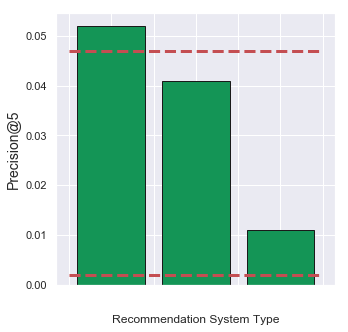

In [727]:
plt.figure(figsize=(5,5))
plt.bar(x=[0, 1, 2], height=[coll_filt, coll_filt_plus_atts, coll_filt_plus_atts_plus_w2v], 
                             color=['#149556', '#149556', '#149556'], edgecolor='k')
plt.plot([-0.5, 2.5], [baseline_random, baseline_random], c='r', linestyle='--', linewidth=3)
plt.plot([-0.5, 2.5], [baseline_top, baseline_top], c='r', linestyle='--', linewidth=3)
plt.ylabel('Precision@5', fontsize=14)
plt.xlabel('Recommendation System Type', labelpad=30)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.savefig('Precision@5.png', dpi=300, bbox_inches='tight')

In [ ]:
#bdaa69

In [729]:
coll_filt = 408
coll_filt_plus_atts = 603
baseline_top = 5

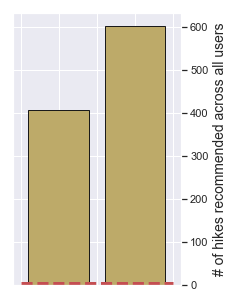

In [740]:
f = plt.figure(figsize=(3,5))
ax= f.add_subplot(111)
ax.bar(x=[0, 1], height=[coll_filt, coll_filt_plus_atts], 
                             color=['#bdaa69', '#bdaa69'], edgecolor='k')
ax.plot([-0.5, 1.5], [baseline_top, baseline_top], c='r', linestyle='--', linewidth=3)
ax.set_ylabel('# of hikes recommended across all users', fontsize=14)
ax.set_xlabel('', labelpad=30)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.savefig('Number_of_hikes_predicted.png', dpi=300, bbox_inches='tight')